## Balance 

In [8]:
import os, random, hashlib, json
from pathlib import Path
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

Balance TRAIN by Augmentation 

In [9]:
# هذا مجلد السبلت اللي طلع من كودك
SPLIT_DIR = Path("/Users/amirah/Ghiras's datast/plant_disease_project2/data_split")
TRAIN_DIR = SPLIT_DIR / "train"      # الصور الأصلية للتدريب

# Main targets
MAIN_TARGET    = 1800    # للكلاسات العادية
RARE_TARGET    = 100     # للكلاسات النادرة جدًا
RARE_THRESHOLD = 50      # أي كلاس أقل من هذا العدد يُعتبر نادر جدًا

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

print("Balancing dataset via class-aware Data Augmentation")
print(f"Main target per normal class: {MAIN_TARGET} images")
print(f"Rare class target: {RARE_TARGET} images (for classes with < {RARE_THRESHOLD} originals)")
print("=" * 80 + "\n")

Balancing dataset via class-aware Data Augmentation
Main target per normal class: 1800 images
Rare class target: 100 images (for classes with < 50 originals)



helper

In [10]:
def is_img(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def load_image_rgb(path: Path):
    try:
        img_bgr = cv2.imread(str(path))
        if img_bgr is None:
            return None
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        return img_rgb
    except:
        return None

def save_image_rgb(img_rgb: np.ndarray, out_path: Path):
    try:
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        cv2.imwrite(str(out_path), img_bgr, [cv2.IMWRITE_JPEG_QUALITY, 90])
    except Exception as e:
        print(f"[ERROR] Failed to save {out_path}: {e}")

Balance TRAIN by Augmentation 

	ما نستخدم grayscale
	•	ما ننفخ نويز قوي.
	•	ما ندور لفوق 20 درجة.
	•	ما نغيّر اللون بشكل يخرّب تشخيص المرض 
	•	ما نقص أجزاء كبيرة من الورقة

    Augment آمن لأوراق نباتات:
    - flip أفقي / عمودي عادي
    - rotate خفيف ±20 درجة
    - تغيير سطوع/كونتراست بسيط
    - تغيير Hue/Saturation بسيط جداً (ما نخليه يخرّب لون المرض)
    - scale / shift بسيييط بدون قص كبير من الورقة


In [11]:
def gentle_augment(img_rgb: np.ndarray) -> np.ndarray:
    out = img_rgb.copy()
    h, w = out.shape[:2]

    # Flip (randomly apply horizontal/vertical/both/none)
    flip_mode = random.choice([None, 0, 1, -1])
    if flip_mode is not None:
        out = cv2.flip(out, flip_mode)

    # Small rotation
    angle = random.uniform(-20, 20)
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)
    out = cv2.warpAffine(out, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

    # Brightness / Contrast adjustment
    alpha = random.uniform(0.9, 1.1)    # contrast
    beta  = random.randint(-15, 15)     # brightness
    out = cv2.convertScaleAbs(out, alpha=alpha, beta=beta)

    # Gentle Hue / Saturation shift
    hsv = cv2.cvtColor(out, cv2.COLOR_RGB2HSV).astype(np.int16)
    hsv[:, :, 0] += random.randint(-3, 3)     # hue shift صغير
    hsv[:, :, 1] += random.randint(-10, 10)   # saturation shift بسيط
    hsv = np.clip(hsv, [0, 0, 0], [179, 255, 255]).astype(np.uint8)
    out = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Slight scale in/out
    scale = random.uniform(0.9, 1.1)
    new_w = int(w * scale)
    new_h = int(h * scale)
    scaled = cv2.resize(out, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Paste scaled image into center of same-size canvas
    canvas = np.zeros_like(out)
    canvas_h, canvas_w = canvas.shape[:2]

    y_off = max((canvas_h - new_h) // 2, 0)
    x_off = max((canvas_w - new_w) // 2, 0)
    y_end = min(y_off + new_h, canvas_h)
    x_end = min(x_off + new_w, canvas_w)

    canvas[y_off:y_end, x_off:x_end] = scaled[:(y_end - y_off), :(x_end - x_off)]
    out = canvas

    # Final resize for model input
    FINAL_SIZE = 224
    out = cv2.resize(out, (FINAL_SIZE, FINAL_SIZE), interpolation=cv2.INTER_AREA)

    return out

Count images per class BEFORE balancing

In [12]:
classes = sorted([d for d in TRAIN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
assert classes, "[ERROR] No classes found in train/"

def count_train_images():
    """حساب عدد الصور لكل كلاس"""
    rows = []
    for c in classes:
        n = sum(1 for p in c.iterdir() if p.is_file() and is_img(p))
        rows.append({"class": c.name, "count": n})
    return pd.DataFrame(rows).sort_values("class").reset_index(drop=True)

df_before = count_train_images()

print("Distribution before balancing (first 10 classes):")
print(df_before.head(10).to_string(index=False))
print(f"\nTotal images (before): {int(df_before['count'].sum()):,}\n")

print("Lowest 10 classes before balancing:")
print(df_before.sort_values("count").head(10).to_string(index=False))
print("\n")

Distribution before balancing (first 10 classes):
                                   class  count
                        Apple_Apple_scab   2016
                         Apple_Black_rot   1987
                  Apple_Cedar_apple_rust   1760
                           Apple_healthy   2000
                       Blueberry_healthy   1453
                   Cherry_Powdery_mildew   1346
                          Cherry_healthy   1461
Corn_Cercospora_leaf_spot Gray_leaf_spot   1314
                       Corn_Common_rust_   1526
               Corn_Northern_Leaf_Blight   1526

Total images (before): 66,934

Lowest 10 classes before balancing:
                          class  count
      plam_Manganese_Deficiency      0
Wilt_and_leaf_blight_on_lettuce      5
         wheat_strip_yellowrust     10
          wheat_leaf_brown_rust     10
          wheat_stem_black_rust     10
     Septoria_blight_on_lettuce     14
      Powdery_mildew_on_lettuce     14
              Lettuce_Bacterial     14
   

Class-aware balancing with augmentation
Starting augmentation with adaptive targets

In [13]:
for cls_dir in tqdm(classes, desc="Processing classes"):
    imgs = [p for p in cls_dir.iterdir() if p.is_file() and is_img(p)]
    cur = len(imgs)

    # choose target for THIS class
    if cur < RARE_THRESHOLD:
        target_for_this_class = RARE_TARGET    # very rare class
    else:
        target_for_this_class = MAIN_TARGET    # normal class

    # skip if already above target
    if cur >= target_for_this_class:
        continue

    # only augment from original images (avoid stacking aug on aug)
    base_imgs = [p for p in imgs if "_aug_" not in p.stem]
    if not base_imgs:
        base_imgs = imgs  # fallback

    need = target_for_this_class - cur
    idx = 0

    with tqdm(total=need, desc=f"  Augmenting {cls_dir.name}", leave=False) as bar:
        while cur < target_for_this_class and base_imgs:
            src = base_imgs[idx % len(base_imgs)]
            img_rgb = load_image_rgb(src)

            if img_rgb is None:
                idx += 1
                continue

            aug_img = gentle_augment(img_rgb)

            out_name = f"{src.stem}_aug_{cur}.jpg"
            out_path = cls_dir / out_name
            save_image_rgb(aug_img, out_path)

            cur += 1
            idx += 1
            bar.update(1)

print("\nAugmentation completed.\n")

Processing classes: 100%|██████████| 96/96 [01:44<00:00,  1.09s/it]


Augmentation completed.



Count images AFTER balancing

In [14]:
df_after = count_train_images()
print("Distribution after balancing (first 10 classes):")
print(df_after.head(10).to_string(index=False))
print(f"\nTotal images (after): {int(df_after['count'].sum()):,}\n")

print("Lowest 10 classes after balancing:")
print(df_after.sort_values("count").head(10).to_string(index=False))
print("\n")


Distribution after balancing (first 10 classes):
                                   class  count
                        Apple_Apple_scab   2016
                         Apple_Black_rot   1987
                  Apple_Cedar_apple_rust   1800
                           Apple_healthy   2000
                       Blueberry_healthy   1800
                   Cherry_Powdery_mildew   1800
                          Cherry_healthy   1800
Corn_Cercospora_leaf_spot Gray_leaf_spot   1800
                       Corn_Common_rust_   1800
               Corn_Northern_Leaf_Blight   1800

Total images (after): 141,809

Lowest 10 classes after balancing:
                          class  count
      plam_Manganese_Deficiency      0
         wheat_strip_yellowrust    100
Wilt_and_leaf_blight_on_lettuce    100
            Lemon_Citrus_Canker    100
        Downy_mildew_on_lettuce    100
      Powdery_mildew_on_lettuce    100
              Lettuce_Bacterial    100
     Septoria_blight_on_lettuce    100
     

Comparing before/after

In [15]:
merged = df_before.merge(df_after, on="class", suffixes=("_before", "_after"))
merged["aug_count"] = merged["count_after"] - merged["count_before"]

print("First 10 classes (before / after / augmented):")
print(merged[["class", "count_before", "count_after", "aug_count"]].head(10).to_string(index=False))

print(f"\nTotal augmented images: {merged['aug_count'].sum():,}\n")



First 10 classes (before / after / augmented):
                                   class  count_before  count_after  aug_count
                        Apple_Apple_scab          2016         2016          0
                         Apple_Black_rot          1987         1987          0
                  Apple_Cedar_apple_rust          1760         1800         40
                           Apple_healthy          2000         2000          0
                       Blueberry_healthy          1453         1800        347
                   Cherry_Powdery_mildew          1346         1800        454
                          Cherry_healthy          1461         1800        339
Corn_Cercospora_leaf_spot Gray_leaf_spot          1314         1800        486
                       Corn_Common_rust_          1526         1800        274
               Corn_Northern_Leaf_Blight          1526         1800        274

Total augmented images: 74,875



Plot class balance

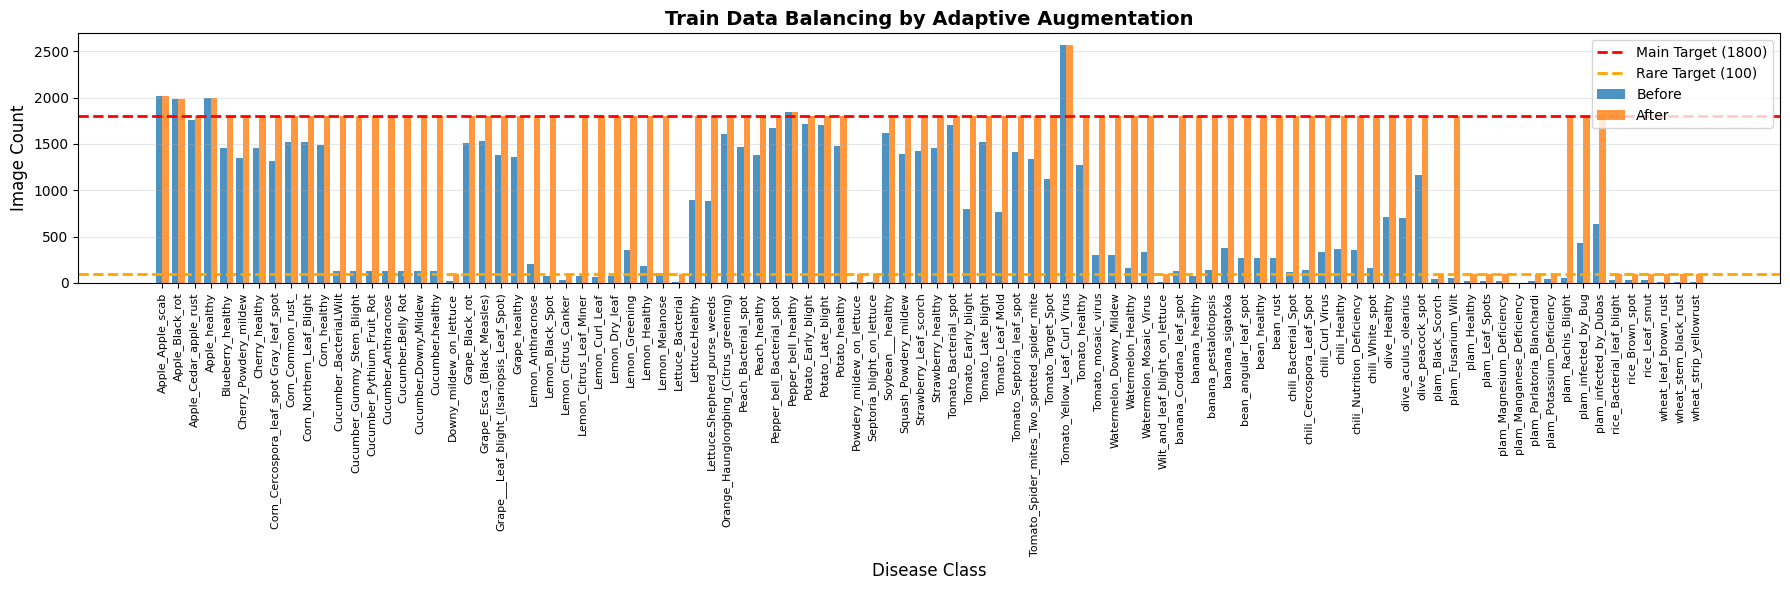

Plot generated.



In [16]:
x = np.arange(len(merged))

plt.figure(figsize=(18, 6))
plt.bar(x - 0.2, merged["count_before"], 0.4, label="Before", alpha=0.8)
plt.bar(x + 0.2, merged["count_after"], 0.4, label="After", alpha=0.8)

# draw reference lines for both targets
plt.axhline(MAIN_TARGET, linestyle="--", color="red", linewidth=2,
            label=f"Main Target ({MAIN_TARGET})")
plt.axhline(RARE_TARGET, linestyle="--", color="orange", linewidth=2,
            label=f"Rare Target ({RARE_TARGET})")

plt.xlabel("Disease Class", fontsize=12)
plt.ylabel("Image Count", fontsize=12)
plt.title("Train Data Balancing by Adaptive Augmentation", fontsize=14, fontweight='bold')
plt.xticks(x, merged["class"], rotation=90, fontsize=8)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Plot generated.\n")

Checking for data leakage between Train / Val / Test

In [17]:
def md5_of_file(path, chunk=1<<20): #حساب MD5 hash للملف
    h = hashlib.md5()
    try:
        with open(path, "rb") as f:
            for ch in iter(lambda: f.read(chunk), b""):
                h.update(ch)
        return h.hexdigest()
    except:
        return None

def hash_split(root: Path):
    hs = set()
    for p in root.rglob("*"):
        if p.is_file() and is_img(p):
            h = md5_of_file(p)
            if h:
                hs.add(h)
    return hs

print("Computing file hashes...")

train_hash = hash_split(SPLIT_DIR / "train")
val_hash   = hash_split(SPLIT_DIR / "val")
test_hash  = hash_split(SPLIT_DIR / "test")

print(f"Train unique files: {len(train_hash):,}")
print(f"Val unique files:   {len(val_hash):,}")
print(f"Test unique files:  {len(test_hash):,}")

leak_train_val  = len(train_hash & val_hash)
leak_train_test = len(train_hash & test_hash)
leak_val_test   = len(val_hash & test_hash)

print("\nLeak check:")
if leak_train_val == 0:
    print(f"Train ∩ Val: {leak_train_val} (No leakage)")
else:
    print(f"Train ∩ Val: {leak_train_val} (LEAK DETECTED)")

if leak_train_test == 0:
    print(f"Train ∩ Test: {leak_train_test} (No leakage)")
else:
    print(f"Train ∩ Test: {leak_train_test} (LEAK DETECTED)")

if leak_val_test == 0:
    print(f"Val ∩ Test: {leak_val_test} (No leakage)")
else:
    print(f"Val ∩ Test: {leak_val_test} (LEAK DETECTED)")

Computing file hashes...
Train unique files: 141,801
Val unique files:   8,366
Test unique files:  8,367

Leak check:
Train ∩ Val: 2 (LEAK DETECTED)
Train ∩ Test: 3 (LEAK DETECTED)
Val ∩ Test: 1 (LEAK DETECTED)


Final summary

In [18]:
total_before = int(df_before['count'].sum())
total_after  = int(df_after['count'].sum())
total_aug    = int(merged['aug_count'].sum())

min_after = int(df_after['count'].min())
max_after = int(df_after['count'].max())

print("\n" + "="*80)
print("Balancing completed successfully.")
print("="*80)

print("\nSummary:")
print(f"  • Total images before: {total_before:,}")
print(f"  • Total images after:  {total_after:,}")
print(f"  • Total augmented:     {total_aug:,}")
print(f"  • Main target (normal classes): {MAIN_TARGET}")
print(f"  • Rare target (rare classes):   {RARE_TARGET}")
print(f"  • Min class size after balancing: {min_after}")
print(f"  • Max class size after balancing: {max_after}")

print("\nStatus:")
# هل جميع الكلاسات الأقل من العتبة وصلوا على الأقل للـ RARE_TARGET؟
# وهل باقي الكلاسات اقتربت من الـ MAIN_TARGET؟
under_main = df_after[(df_after["count"] < MAIN_TARGET) & (df_after["count"] >= RARE_THRESHOLD)]
under_rare = df_after[(df_after["count"] < RARE_TARGET) & (df_after["count"] < RARE_THRESHOLD)]

if len(under_rare) == 0:
    print("All rare classes reached at least the rare target.")
else:
    print(f"{len(under_rare)} rare classes are still below the rare target.")

print("\nTraining data is ready.")
print("="*80)


Balancing completed successfully.

Summary:
  • Total images before: 66,934
  • Total images after:  141,809
  • Total augmented:     74,875
  • Main target (normal classes): 1800
  • Rare target (rare classes):   100
  • Min class size after balancing: 0
  • Max class size after balancing: 2566

Status:
1 rare classes are still below the rare target.

Training data is ready.
